### make meta features using Potential energy only available for train set

### 分子の特徴なので分子記述子を計算する 

In [24]:
import sys
sys.path.insert(0, "/home/kohei3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/")
import pickle
import re

import numpy as np
import pandas as pd
import feather
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, Descriptors3D, MACCSkeys

In [4]:
#load in mol files
with open('../data/input/mols_without_Hs.pickle', 'rb') as f:
    df = pickle.load(f)
    
potential = feather.read_dataframe("../data/input/potential_energy.feather")
df.shape, potential.shape

((133885, 2), (85003, 2))

In [5]:
df.head()

,ids,mols
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x00000180849...
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x00000180849...
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x00000180849...
3,dsgdb9nsd_000004,<rdkit.Chem.rdchem.Mol object at 0x00000180849...
4,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x00000180849...


In [6]:
potential.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [7]:
#store functions in Descriptor, Descriptor3D modules in lists
desc_2Ds = [v for k, v in Descriptors.__dict__.items() if not '__' in k and not bool(re.match('_', k)) and callable(v)]
desc_3Ds = [v for k, v in Descriptors3D.__dict__.items() if not '__' in k and not bool(re.match('_', k)) and callable(v)]
desc_2Ds_cols = [k for k, v in Descriptors.__dict__.items() if not '__' in k and not bool(re.match('_', k)) and callable(v)]
desc_3Ds_cols = [k for k, v in Descriptors3D.__dict__.items() if not '__' in k and not bool(re.match('_', k)) and callable(v)]
desc_cols = desc_2Ds_cols + desc_3Ds_cols

#function for skipping molecules with no mol file
def skip_nan(func, mol):
    try:
        return func(mol)
    except:
        return np.nan

for desc_2D, desc_2Ds_col in zip(desc_2Ds, desc_2Ds_cols):
    df[desc_2Ds_col] = df['mols'].apply(lambda mol: skip_nan(desc_2D, mol))
for desc_3D, desc_3Ds_col in zip(desc_3Ds, desc_3Ds_cols):
    df[desc_3Ds_col] = df['mols'].apply(lambda mol: skip_nan(desc_3D, mol))

In [8]:
df.head()

,ids,mols,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,PMI1,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.031300,...,0.000000e+00,3.614429e-35,3.614429e-35,0.000000e+00,0.0,1.734723e-18,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.397555,17.031,14.007,17.026549,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.327748,18.015,15.999,18.010565,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000004,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,4.0,4.0,4.0,4.0,0.332926,26.038,24.022,26.015650,...,0.000000e+00,8.633513e+00,8.633513e+00,0.000000e+00,1.0,5.995000e-01,0.0,1.0,1.0,0.0
4,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,6.5,3.5,6.5,3.5,0.369797,27.026,26.018,27.010899,...,-2.324980e-19,8.578715e+00,8.578715e+00,-2.710173e-20,1.0,5.742145e-01,0.0,1.0,1.0,0.0


In [13]:
BIT_LENGTH = 167
maccs_keys = []
for i in tqdm(range(len(df))):
    try:
        arr = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(df['mols'][i]), arr)
        maccs_keys.append(arr)
    except:
        maccs_keys.append(np.full(BIT_LENGTH, np.nan))

for maccs_index in range(0, 167):
    df[f'maccs_{maccs_index}'] = np.array(maccs_keys)[:, maccs_index]  #ignore index 0

100%|███████████████████████████████████████████████████████████████████| 133885/133885 [01:34<00:00, 1416.78it/s]


In [15]:
df.head()

,ids,mols,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.031300,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.397555,17.031,14.007,17.026549,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.327748,18.015,15.999,18.010565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,dsgdb9nsd_000004,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,4.0,4.0,4.0,4.0,0.332926,26.038,24.022,26.015650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,6.5,3.5,6.5,3.5,0.369797,27.026,26.018,27.010899,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
train = feather.read_dataframe('../data/input/train.feather')
test = feather.read_dataframe('../data/input/test.feather')

In [17]:
train.shape

(4658147, 6)

In [18]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [20]:
train_df = df.loc[df['ids'].isin(train['molecule_name'].unique()), :]
test_df = df.loc[df['ids'].isin(test['molecule_name'].unique()), :]

In [21]:
train_df.head()

,ids,mols,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.359785,16.043,12.011,16.031300,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.397555,17.031,14.007,17.026549,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,0.0,0.0,0.0,0.0,0.327748,18.015,15.999,18.010565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,6.5,3.5,6.5,3.5,0.369797,27.026,26.018,27.010899,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,dsgdb9nsd_000007,<rdkit.Chem.rdchem.Mol object at 0x00000180849...,2.0,2.0,2.0,2.0,0.372786,30.070,24.022,30.046950,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
train_df.shape

(85003, 380)

In [23]:
potential.shape

(85003, 2)

In [25]:
train_potential_oof = np.zeros(len(train_df))
test_potential_pred = np.zeros(len(test_df))


kf = KFold(n_splits=2, shuffle=True, random_state=42)

target = potential['potential_energy']
#mulliken.drop('mulliken_charge', axis=1, inplace=True)

cols = [col for col in train_df.columns if col not in ['ids', 'mols']]

SEED = 42
NUM_ROUNDS = 10000

params = {
        "num_leaves": 90,
        "min_data_in_leaf": 100,
        "objective": "regression",
        "max_depth": 8,
        "learning_rate": 0.2,
        "boosting_type": "gbdt",
        "subsample_freq": 1,
        "subsample": 0.9,
        "metric": "mae",
        "reg_alpha": 0.1,
        "reg_lambda": 0.3, 
        "colsample_bytree": 0.9
        }

for train_idx, val_idx in kf.split(train_df):
        train_data = lgb.Dataset(train_df[cols].iloc[train_idx], label=target.iloc[train_idx])
        val_data = lgb.Dataset(train_df[cols].iloc[val_idx], label=target.iloc[val_idx])
        clf = lgb.train(params, train_data, NUM_ROUNDS, valid_sets=[train_data, val_data],
                        verbose_eval=1000, early_stopping_rounds=100)
        train_potential_oof[val_idx] = clf.predict(train_df[cols].iloc[val_idx], num_iteration=clf.best_iteration)
        test_potential_pred += clf.predict(test_df[cols], num_iteration=clf.best_iteration) / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.496687	valid_1's l1: 0.537497
[2000]	training's l1: 0.428878	valid_1's l1: 0.504617
[3000]	training's l1: 0.395669	valid_1's l1: 0.493778
[4000]	training's l1: 0.373066	valid_1's l1: 0.488226
Early stopping, best iteration is:
[4642]	training's l1: 0.362841	valid_1's l1: 0.486682
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.442217	valid_1's l1: 0.575325
[2000]	training's l1: 0.379647	valid_1's l1: 0.547253
[3000]	training's l1: 0.347979	valid_1's l1: 0.537243
[4000]	training's l1: 0.327454	valid_1's l1: 0.533726
Early stopping, best iteration is:
[4886]	training's l1: 0.314077	valid_1's l1: 0.53209


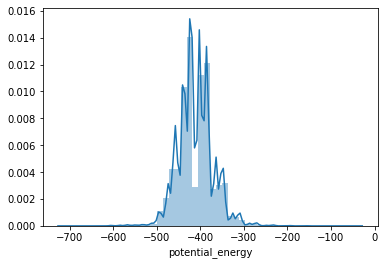

In [28]:
import seaborn as sns
%matplotlib inline

sns.distplot(target)

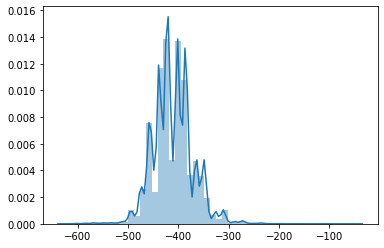

In [29]:
sns.distplot(train_potential_oof)

In [30]:
potential.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [31]:
train_potential_oof

array([ -69.06304574,  -46.88953592,  -48.92322456, ..., -401.12355848,
       -401.09352765, -365.10350003])

In [39]:
train_oof = pd.DataFrame({'molecule_name': train['molecule_name'].unique(),
                        'potential_oof': train_potential_oof})

test_oof = pd.DataFrame({'molecule_name': test['molecule_name'].unique(),
                        'potential_oof': test_potential_pred})

In [40]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [41]:
train = train.merge(train_oof, on=['molecule_name'], how='left')

test = test.merge(test_oof, on=['molecule_name'], how='left')

In [42]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,potential_oof
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,-69.063046
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-69.063046
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-69.063046
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-69.063046
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,-69.063046


In [44]:
train['potential_oof'].to_frame().to_feather('../features/PotentialPred_train.feather')
test['potential_oof'].to_frame().to_feather('../features/PotentialPred_test.feather')